In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm

In [430]:
df = pd.read_csv('dataforreg.csv')
df['ret'] = df.groupby('S_INFO_WINDCODE')['S_DQ_CLOSE'].pct_change()
df = df.dropna()
df = df.sort_values(by=['TRADE_DT','S_INFO_WINDCODE'])
df.reset_index(drop = True, inplace = True)
df

,S_INFO_WINDCODE,TRADE_DT,S_DQ_CLOSE,S_FA_ROE,Skewness20,WVAD,S_VAL_PS,NET_ASSETS_TODAY,TOT_CUR_LIAB,ret
0,000333.SZ,2017-02-07,29.65,26.6193,0.387597,3.977220e+05,1.3816,5.838518e+10,8.918400e+10,-0.011337
1,000651.SZ,2017-02-07,25.13,30.4205,0.920298,7.536173e+04,1.5466,4.974506e+10,1.268763e+11,-0.005146
2,002352.SZ,2017-02-07,42.02,39.4012,-0.675897,-1.855552e+04,262.9876,7.064836e+08,1.838696e+10,0.001669
3,002415.SZ,2017-02-07,25.85,34.0921,-0.021234,1.502265e+05,6.2960,2.148254e+10,1.180213e+10,-0.005769
4,600276.SH,2017-02-07,47.95,6.3449,-0.013840,-4.681542e+04,12.0826,1.106312e+10,1.520011e+09,-0.006835
...,...,...,...,...,...,...,...,...,...,...
9069,000651.SZ,2022-07-01,33.45,39.4012,0.627172,7.112407e+04,1.0531,9.179914e+10,1.838696e+10,-0.008007
9070,002352.SZ,2022-07-01,55.98,34.0921,0.295832,8.496753e+05,1.3226,8.111260e+10,1.180213e+10,0.003046
9071,002415.SZ,2022-07-01,35.80,6.3449,0.477988,2.014381e+05,4.1477,5.744570e+10,1.520011e+09,-0.011050
9072,600276.SH,2022-07-01,38.94,8.0614,0.079993,2.764268e+06,9.5886,3.624272e+10,3.650926e+10,0.049879


In [431]:
timestep = 1  # 时间步长，就是利用多少时间窗口
batch_size = 32  # 批次大小
input_dim = 8 # 每个步长对应的特征数量，就是使用每天的8个特征
hidden_dim = 64  # 隐层大小
output_dim = 1  # 由于是回归任务，最终输出层大小为1
num_layers = 3  # LSTM的层数
epochs = 300
best_loss = 0
model_name = 'LSTM'
save_path = './{}.pth'.format(model_name)

# 2.将数据进行标准化
scaler = StandardScaler()
scaler_model = StandardScaler()
data = scaler_model.fit_transform(np.array(df.iloc[:,2:])).reshape(-1,8)
scaler.fit_transform(np.array(df['ret']).reshape(-1, 1))

# 形成训练数据，例如12345变成12-3，23-4，34-5
def split_data(data, timestep):
    dataX = []  # 保存X
    dataY = []  # 保存Y

    # 将整个窗口的数据保存到X中，将未来一天保存到Y中
    for index in range(len(data) - timestep):
        dataX.append(data[index: index + timestep])
        dataY.append(data[index + timestep][-1])

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    # 获取训练集大小
    train_size = int(np.round(0.7 * dataX.shape[0]))

    # 划分训练集、测试集
    x_train = dataX[: train_size, :].reshape(-1, timestep, 8)
    y_train = dataY[: train_size]

    x_test = dataX[train_size:, :].reshape(-1, timestep, 8)
    y_test = dataY[train_size:]

    return [x_train, y_train, x_test, y_test]

# 3.获取训练数据   x_train: 1700,1,1
x_train, y_train, x_test, y_test = split_data(data, timestep)

# 4.将数据转为tensor
x_train_tensor = torch.from_numpy(x_train).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32)
x_test_tensor = torch.from_numpy(x_test).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32)

# 5.形成训练数据集
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

# 6.将数据加载成迭代器
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size,
                                           True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size,
                                          False)


# 7.定义LSTM网络
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim  # 隐层大小
        self.num_layers = num_layers  # LSTM层数
        # input_dim为特征维度，就是每个时间点对应的特征数量，这里为4
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)  # output为所有时间片的输出，形状为：16,1,4
        # print(output.shape) torch.Size([16, 1, 64]) batch_size,timestep,hidden_dim
        # print(h_n.shape) torch.Size([3, 16, 64]) num_layers,batch_size,hidden_dim
        # print(c_n.shape) torch.Size([3, 16, 64]) num_layers,batch_size,hidden_dim
        batch_size, timestep, hidden_dim = output.shape

        # 将output变成 batch_size * timestep, hidden_dim
        output = output.reshape(-1, hidden_dim)
        output = self.fc(output)  # 形状为batch_size * timestep, 1
        output = output.reshape(timestep, batch_size, -1)
        return output[-1]  # 返回最后一个时间片的输出


model = LSTM(input_dim, hidden_dim, num_layers, output_dim)  # 定义LSTM网络
loss_function = nn.MSELoss()  # 定义损失函数
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)  # 定义优化器

# 8.模型训练
for epoch in range(epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for data in train_bar:
        x_train, y_train = data  # 解包迭代器中的X和Y
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_function(y_train_pred, y_train.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)

    # 模型验证
    model.eval()
    test_loss = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader)
        for data in test_bar:
            x_test, y_test = data
            y_test_pred = model(x_test)
            test_loss = loss_function(y_test_pred, y_test.reshape(-1, 1))

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), save_path)

print('Finished Training')

  0%|          | 0/199 [00:00<?, ?it/s]

100%|██████████| 86/86 [00:00<00:00, 553.59it/s]

Finished Training


In [453]:
a = scaler.inverse_transform((model(x_train_tensor).detach().numpy()).reshape(-1, 1))
b = scaler.inverse_transform(y_test_pred.detach().numpy())
c = np.vstack((a, b))
df.drop (df.index[0], inplace = True)
df['ret_pred_lstm'] = c
df

In [455]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

actuals = df['ret']
predictions = df['ret_pred_lstm']

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print("Performance Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

Performance Metrics:
MSE: 0.0002796594934990607
MAE: 0.00999564360399451
R^2: 0.448968648804564


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


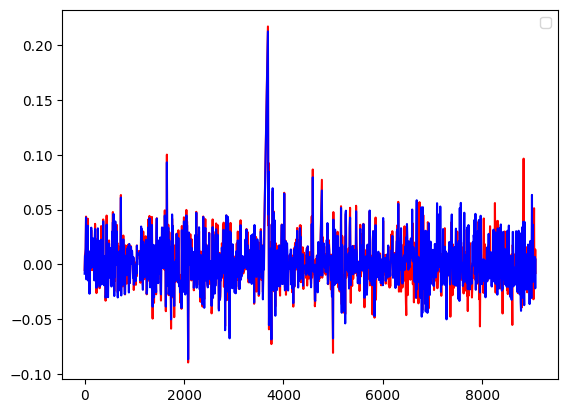

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


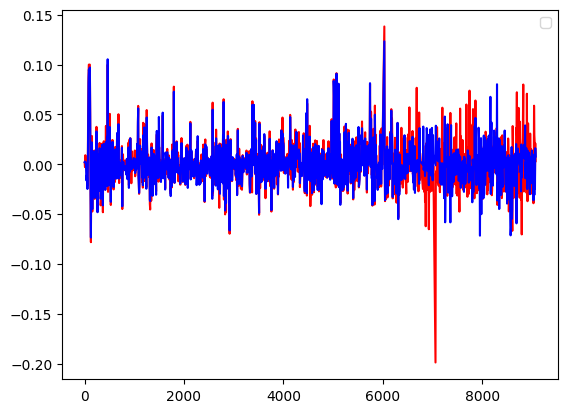

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


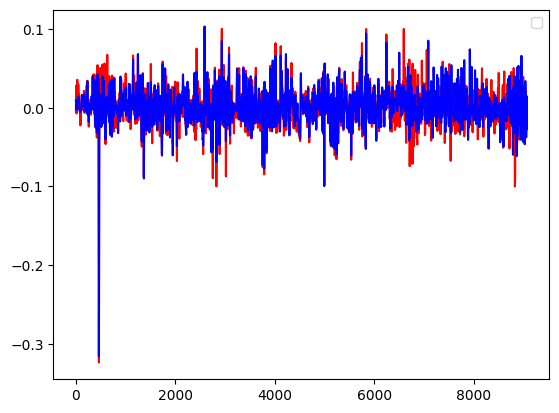

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


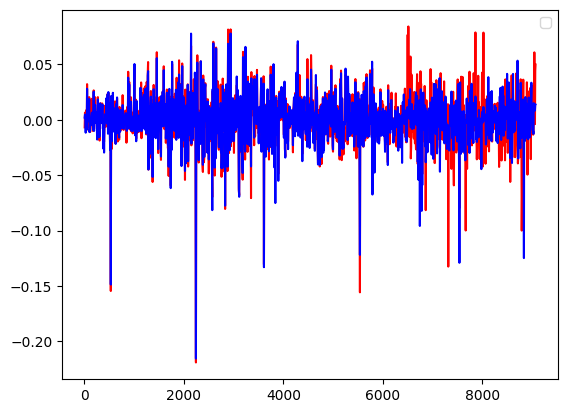

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


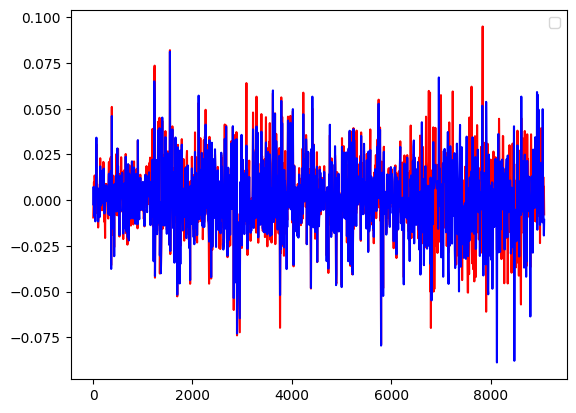

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


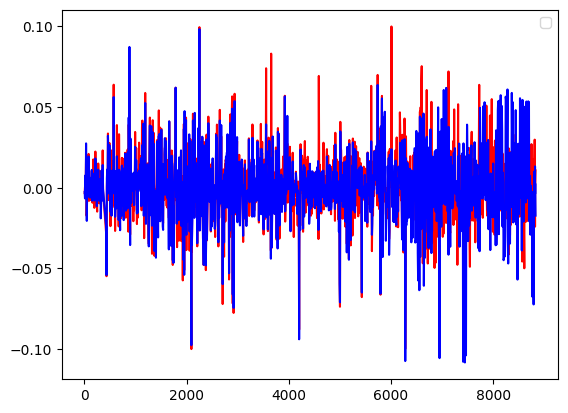

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


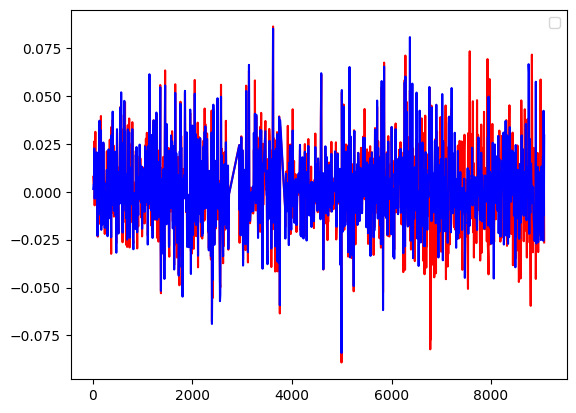

In [459]:
for name in df['S_INFO_WINDCODE'].unique():
    plt.plot(df[df['S_INFO_WINDCODE'] == name]['ret'], "r")
    plt.plot(df[df['S_INFO_WINDCODE'] == name]['ret_pred_lstm'], "b")
    plt.legend()
    plt.show()